<a href="https://colab.research.google.com/github/skyshine460/Datascience_notebook/blob/main/submit_moving48.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [347]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [348]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [349]:
import os  # osモジュールをインポート
import tensorflow as tf
import numpy as np
import random

# シードを固定
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(1)

# 決定論的な動作を確保するための設定
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # TensorFlowで決定論的な動作を保証
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # cuDNNで決定論的な動作を保証

In [350]:
df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test.csv")
sample_submit = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/sample_submit.csv", header=None)

In [351]:
# 事前に作成した特徴量データをインポート
merged_df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/merged_df_2.csv")
df = merged_df.copy()

In [352]:
pd.set_option('display.max_columns', None)
df[:1917].describe()
# 2011-01-01 ~ 2016-03-31

,y,client,price_am,price_pm,trend,seasonal,residual,y_bc_1_2,client_mean,price_am_mean,price_pm_mean,is_train,y_lag_365,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1891.000000,1891.000000,1917.0,1552.000000,1916.000000,1916.000000,1910.000000,1910.000000,1887.000000,1887.000000,1827.000000,1827.000000,1552.000000,1552.000000,1911.000000,1888.000000,1828.000000,1911.000000,1888.000000,1828.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1.917000e+03
mean,35.804903,0.107460,0.769953,0.525300,35.637599,0.249529,-0.082225,9.557925,41.804802,43.927762,44.016278,1.0,33.386598,0.767745,0.523486,0.756021,0.511518,0.745098,0.498145,0.752600,0.504652,0.771263,0.525129,0.766166,0.758651,0.752747,0.521716,0.510876,0.505191,2013.141888,6.308816,15.725613,2.999478,25.718832,2.699531,0.285863,0.032864,0.032864,2.437141,0.010955,0.010955,0.003130,0.002608,1.0,2.514345,3.498174,0.018258,0.010433,0.017214,526612.188445,4.119433,97.772238,101.879874,101.142499,99.264799,3.000000e-01
std,17.262632,0.309777,1.057716,0.914971,9.280903,12.925255,5.035453,3.104678,3.044833,11.447007,11.242253,0.0,16.148330,1.053565,0.911758,1.033819,0.887385,1.027819,0.871288,1.032913,0.876463,1.066396,0.909517,0.775024,0.533381,0.336354,0.684850,0.469456,0.286153,1.520803,3.505973,8.800553,2.000913,15.330926,1.268893,0.451943,0.178327,0.178327,1.136709,0.104117,0.104117,0.055872,0.051018,0.0,1.138356,1.708270,0.133917,0.101634,0.130103,10227.154958,0.513904,1.736938,2.430198,0.678858,0.292215,2.165500e-15
min,0.000000,0.000000,-1.000000,-1.000000,18.100942,-47.954564,-27.424270,-2.000000,40.748571,34.931429,36.864745,1.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.571429,-0.066667,0.266667,-0.571429,-0.100000,0.133333,2011.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,503949.300000,3.400000,95.698650,98.808200,99.387086,98.893476,3.000000e-01
25%,23.000000,0.000000,0.000000,0.000000,27.808185,-7.709907,-3.325194,7.591663,40.748571,34.931429,36.864745,1.0,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.466667,0.544444,0.142857,0.266667,0.322222,2012.000000,3.000000,8.000000,1.000000,12.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,2.000000,0.000000,0.000000,0.000000,517290.437363,3.632258,96.275557,99.766675,100.609987,99.091660,3.000000e-01
50%,34.000000,0.000000,0.000000,0.000000,39.861618,-0.911151,-0.201739,9.661904,40.748571,34.931429,36.864745,1.0,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.600000,0.611111,0.285714,0.366667,0.366667,2013.000000,6.000000,16.000000,3.000000,25.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,3.000000,3.000000,0.000000,0.000000,0.000000,527621.807609,4.138710,96.966314,101.591800,101.188638,99.1

In [353]:
pd.set_option('display.max_columns', None)
df[1917:].describe()
# 2016-04-01 ~ 2017-03-31

,y,client,price_am,price_pm,trend,seasonal,residual,y_bc_1_2,client_mean,price_am_mean,price_pm_mean,is_train,y_lag_365,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N
count,0.0,365.000000,365.000000,365.000000,0.0,0.0,0.0,0.0,365.000000,360.000000,360.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,3.650000e+02
mean,NaN,0.452055,0.794521,0.586301,NaN,NaN,NaN,NaN,45.191863,44.248109,44.868842,0.0,46.087671,0.794521,0.586301,0.800000,0.594521,0.786301,0.572603,0.780822,0.564384,0.764384,0.526027,0.798434,0.795068,0.787245,0.590215,0.583927,0.571385,2016.246575,6.526027,15.720548,3.002740,26.463014,2.698630,0.284932,0.032877,0.032877,2.509589,0.010959,0.010959,0.002740,0.002740,1.0,2.490411,3.515068,0.019178,0.010959,0.016438,544332.606986,3.167945,99.974418,108.485682,102.799637,98.918724,3.000000e-01
std,NaN,0.498379,1.002180,0.958667,NaN,NaN,NaN,NaN,4.898618,10.775812,11.770860,0.0,18.069098,1.002180,0.958667,1.019588,0.986153,1.012737,0.951179,1.008842,0.937229,1.021388,0.939082,0.755868,0.552362,0.343597,0.775468,0.582155,0.354027,0.431609,3.452584,8.808321,2.000685,15.024956,1.269734,0.452001,0.178559,0.178559,1.118300,0.104252,0.104252,0.052342,0.052342,0.0,1.118300,1.712244,0.137339,0.104252,0.127329,2658.157620,0.116446,0.218077,1.382975,0.233800,0.061306,1.834383e-15
min,NaN,0.000000,-1.000000,-1.000000,NaN,NaN,NaN,NaN,40.748571,34.931429,36.864745,0.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.571429,0.033333,0.400000,-0.571429,-0.066667,0.244444,2016.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,541020.600000,2.900000,99.669130,106.808900,102.316374,98.794385,3.000000e-01
25%,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,40.748571,34.931429,36.864745,0.0,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.500000,0.577778,0.285714,0.333333,0.333333,2016.000000,4.000000,8.000000,1.000000,13.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,2.000000,0.000000,0.000000,0.000000,542199.100000,3.100000,99.845592,107.402463,102.638977,98.893476,3.000000e-01
50%,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,40.748571,47.388646,36.864745,0.0,44.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.571429,0.633333,0.633333,0.428571,0.400000,0.388889,2016.000000,7.000000,16.000000,3.000000,26.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.000000,4.000000,0.000000,0.000000,0.000000,542884.072826,3.180645,99.928571,107.688462,102.791409,98.893476,3.000000e-01
75%,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,50.577670,47.388646,51.140625,0.0,56.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,0.955556,0.

# データ処理

In [354]:
# 年度の初日をindex出力
dates = ["2011-04-01", "2012-04-01", "2013-04-01", "2014-04-01", "2015-04-01", "2016-04-01"]

for date in dates:
    print(f"{date}:", df[df["datetime"] == date].index)

2011-04-01: Index([90], dtype='int64')
2012-04-01: Index([456], dtype='int64')
2013-04-01: Index([821], dtype='int64')
2014-04-01: Index([1186], dtype='int64')
2015-04-01: Index([1551], dtype='int64')
2016-04-01: Index([1917], dtype='int64')


In [355]:
# 別で時系列を作成するので削除
df.drop(['seasonal', 'trend', 'residual', 'y_bc_1_2', 'y_lag_365', 'is_train'], axis=1, inplace=True)

# df.drop(["price_am_lag_1","price_pm_lag_1",
#          "price_am_lag_7","price_pm_lag_7",
#          "price_am_lag_30","price_pm_lag_30",
#          "price_am_lag_90","price_pm_lag_90",
#          "price_am_lag_365","price_pm_lag_365",
#          "price_am_moving_avg_7","price_pm_moving_avg_7",
#          "price_am_moving_avg_30","price_pm_moving_avg_30",
#          "price_am_moving_avg_90","price_pm_moving_avg_90"
#          ], axis=1, inplace=True)

# タイムステップ(秒単位)に変更
df['datetime'] = pd.to_datetime(df['datetime'])
df['timestamp_s'] = df['datetime'].apply(lambda x: x.timestamp())
df = df.drop(['datetime'], axis=1)

# 欠損値は一旦０に
df = df.fillna(0)

In [356]:
# # 指標データの特徴量を作成
# economic_cols = ['JPNRGDPEXP', 'LRUN64TTJPM156S', 'JPNCPIALLMINMEI', 'QJPN628BIS', 'LCEAPR03JPM661S', 'JPNCPIHOUMINMEI', 'IRSTCB01JPM156N']

# lags = [1, 7, 30, 90, 365]
# for col in economic_cols:
#     for lag in lags:
#         # ラグ特徴量
#         df[f"{col}_lag_{lag}"] = df[col].shift(lag)
#         # 差分特徴量
#         df[f"{col}_diff_{lag}"] = df[col].shift(lag) - df[col]

# df = df.fillna(0)

In [357]:
# MinMaxScalerでスケーリング
from sklearn.preprocessing import MinMaxScaler

# 特徴量用のスケーラー
scaler_features = MinMaxScaler(feature_range=(0, 1))

# ターゲット変数用のスケーラー
scaler_target = MinMaxScaler(feature_range=(0, 1))

# 元のデータフレームの列名
feature_columns = df.drop(columns=['y']).columns
target_column = ['y']

# 特徴量とターゲット変数を分けてスケーリング
input_features_scaled = scaler_features.fit_transform(df.drop(columns=['y']))  # 特徴量のスケーリング
target_values_scaled = scaler_target.fit_transform(df[['y']])  # 目的変数 'y' のスケーリング

# スケーリングされた特徴量と目的変数を元のデータフレームに戻す
scaled_df = pd.DataFrame(input_features_scaled, columns=feature_columns)  # 特徴量をデータフレームに戻す
scaled_df['y'] = target_values_scaled  # 目的変数 'y' を追加

In [358]:
train_df = scaled_df[:1917] # 2011-01-01 ~ 2016-03-31
test_df = scaled_df[821:] # 2013-04-01 ~ 2017-03-31

In [359]:
pd.set_option('display.max_columns', None)
print(train_df.shape)
train_df.describe()

(1917, 51)


,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N,timestamp_s,y
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000
mean,0.107460,0.294992,0.254217,0.107460,0.476758,0.480656,0.294557,0.253869,0.292210,0.251608,0.288906,0.248392,0.286211,0.246827,0.270736,0.237524,0.252605,0.271280,0.458170,0.206502,0.218005,0.377011,0.356981,0.482620,0.490854,0.499913,0.475362,0.424883,0.285863,0.032864,0.032864,0.479047,0.010955,0.010955,0.003130,0.002608,0.0,0.504782,0.499635,0.018258,0.010433,0.017214,0.499857,0.554288,0.433356,0.255241,0.447530,0.431569,0.0,0.419991,0.328485
std,0.309777,0.176286,0.152495,0.309777,0.137017,0.135855,0.175573,0.151933,0.172156,0.147717,0.170655,0.144442,0.170143,0.143711,0.167689,0.140650,0.146620,0.179124,0.232762,0.129481,0.169896,0.233978,0.253467,0.318725,0.293352,0.333486,0.294825,0.317223,0.451943,0.178327,0.178327,0.378903,0.104117,0.104117,0.055872,0.051018,0.0,0.379452,0.341654,0.133917,0.101634,0.130103,0.225572,0.233593,0.363000,0.201938,0.173070,0.268085,0.0,0.242672,0.158373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227273,0.000000,0.000000,0.000000,0.090909,0.0,0.000000,0.000000
25%,0.000000,0.166667,0.166667,0.000000,0.384331,0.408097,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.162162,0.177778,0.340426,0.135135,0.132530,0.243478,0.166667,0.181818,0.233333,0.166667,0.211538,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.294255,0.332845,0.120567,0.079645,0.311770,0.272727,0.0,0.209996,0.211009
50%,0.000000,0.166667,0.166667,0.000000,0.384331,0.408097,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.216216,0.222222,0.382979,0.162162,0.168675,0.286957,0.333333,0.454545,0.500000,0.500000,0.461538,0.500000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.666667,0.400000,0.000000,0.000000,0.000000,0.522125,0.563050,0.264927,0.231304,0.459292,0.281525,0.0,0.419991,0.311927
75%,0.000000,0.333333,0.333333,0.000000,0.521391,0.566132,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.297297,0.288889,0.517730,0.216216,0.216867,0.434783,0.500000,0.727273,0.733333,0.833333,0.730769,0.750000,1.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.800000,0.000000,0.000000,0.000000,0.704573,0.752199,0.847630,0.447305,0.579914,0.636364,0.0,0.629987

In [360]:
pd.set_option('display.max_columns', None)
print(test_df.shape)
test_df.describe()

(1461, 51)


,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N,timestamp_s,y
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.0,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.0,1461.000000,1461.000000
mean,0.253936,0.295117,0.255191,0.253936,0.476800,0.481445,0.295117,0.255191,0.294889,0.255076,0.294433,0.253479,0.294547,0.253023,0.292836,0.251996,0.254028,0.279147,0.489609,0.208798,0.226615,0.407886,0.624572,0.502085,0.490988,0.499430,0.493182,0.425051,0.284736,0.032854,0.032854,0.502852,0.010951,0.010951,0.002738,0.002738,0.0,0.497148,0.500890,0.019165,0.010951,0.016427,0.723986,0.313811,0.732717,0.498035,0.581522,0.206677,0.0,0.679965,0.291826
std,0.435410,0.171959,0.153834,0.435410,0.133947,0.136643,0.171959,0.153834,0.171242,0.153467,0.173458,0.151264,0.173209,0.150391,0.173750,0.151165,0.143486,0.183255,0.219659,0.135462,0.184916,0.242215,0.199781,0.313626,0.293437,0.333304,0.290206,0.317355,0.451443,0.178316,0.178316,0.372488,0.104110,0.104110,0.052271,0.052271,0.0,0.372488,0.342242,0.137152,0.104110,0.127155,0.136759,0.158325,0.272212,0.228336,0.230105,0.086370,0.0,0.184962,0.211786
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170213,0.000000,0.000000,0.104348,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.495023,0.000000,0.106384,0.146812,0.000000,0.000000,0.0,0.359930,0.000000
25%,0.000000,0.166667,0.166667,0.000000,0.384331,0.408097,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.189189,0.188889,0.354610,0.135135,0.144578,0.252174,0.500000,0.272727,0.233333,0.166667,0.250000,0.250000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.614534,0.227273,0.767328,0.291724,0.404681,0.112121,0.0,0.519947,0.000000
50%,0.000000,0.333333,0.166667,0.000000,0.521391,0.408097,0.333333,0.166667,0.333333,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.216216,0.233333,0.397163,0.162162,0.168675,0.286957,0.666667,0.545455,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.600000,0.000000,0.000000,0.000000,0.751654,0.272727,0.855866,0.493900,0.599014,0.231975,0.0,0.679965,0.321101
75%,1.000000,0.333333,0.333333,1.000000,0.521391,0.566132,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.297297,0.288889,0.581560,0.216216,0.216867,0.521739,0.833333,0.818182,0.733333,0.833333,0.750000,0.750000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.666667,0.800000,0.000000,0.000000,0.000000,0.830082,0.409091,0.913527,0.692010,0.791501,0.272727,0.0,0.839982

In [361]:
test_df = test_df.drop(['y'], axis=1)

In [362]:
# import matplotlib.pyplot as plt

# # val_df と test_df の特徴量の分布をヒストグラムで確認
# for col in df.drop(columns=['y']).columns:
#     plt.figure(figsize=(10, 5))
#     plt.hist(df[821:1917][col], bins=30, alpha=0.5, label='val_df')
#     plt.hist(df[1917:][col], bins=30, alpha=0.5, label='test_df')
#     plt.title(f'Feature: {col}')
#     plt.legend()
#     plt.show()


# LSTMモデル

In [363]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber  # Huber損失関数をインポート
import tensorflow as tf
import numpy as np

# LSTMモデルを定義
def create_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        # LSTM(32, return_sequences=False,),
        Dense(1, activation='relu')    # 出力層。予測する値が1つの場合
    ])
    return model

# 'y'列を除いたデータを使う
input_features = train_df.drop(columns=['y']).values  # 特徴量のみ
input_shape = (365, input_features.shape[1])  # 365日分のデータと、特徴量の数
model = create_model(input_shape)

# モデルのコンパイルと訓練
def compile_and_fit(model, input_features, target_values, patience=3, max_epochs=50):
    # EarlyStoppingコールバックを定義
    early_stopping = EarlyStopping(monitor='loss', patience=patience, mode='min', restore_best_weights=True)

    # モデルをコンパイル
    optimizer = Adam(learning_rate=0.001)  # デフォルトの学習率は0.001
    model.compile(loss=Huber(), optimizer=optimizer, metrics=[MeanAbsoluteError()])

    # データをウィンドウに分割（365日分のデータを持つウィンドウを作成）
    input_data = []
    target_data = []

    for i in range(len(input_features) - 365):
        input_data.append(input_features[i:i + 365])  # 特徴量のみ
        target_data.append(target_values[i + 365])  # 'y'列のターゲット値

    input_data = np.array(input_data)
    target_data = np.array(target_data)

    # モデルの訓練実行
    history = model.fit(input_data, target_data, epochs=max_epochs, callbacks=[early_stopping], verbose=1)

    return history, input_data  # input_dataも返す

# 'y'列をターゲット値として取得
target_values = train_df['y'].values

# トレーニング実行
history, input_data = compile_and_fit(model, input_features, target_values)  # 特徴量とターゲット値を渡す

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.0103 - mean_absolute_error: 0.1132
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - loss: 0.0043 - mean_absolute_error: 0.0721
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 0.0038 - mean_absolute_error: 0.0661
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - loss: 0.0034 - mean_absolute_error: 0.0625
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 0.0031 - mean_absolute_error: 0.0597
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - loss: 0.0029 - mean_absolute_error: 0.0577
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 0.0027 - mean_absolute_error: 0.0566
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.0026 - mean_absolute_error: 0.0556
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - loss: 0.0025 - mean_absolute_error: 0.0547
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 0.0024 - mean_absolute_error: 0.0540
Epoch 11/50
49/49 ━━━━━━━━━

In [364]:
# test_dfで予測を行う関数
def predict_test_data(model, test_df, window_size=365):
    test_input_features = test_df # 'y'列を除いた特徴量のみ
    test_input_data = []

    # test_dfをウィンドウに分割（365日分のデータを持つウィンドウを作成）
    for i in range(len(test_input_features) - window_size):
        test_input_data.append(test_input_features[i:i + window_size])  # 365日分のデータを使用

    test_input_data = np.array(test_input_data)

    # 予測を実行
    test_predictions_scaled = model.predict(test_input_data)

    return test_predictions_scaled

# test_dfで予測を実行
test_predictions_scaled = predict_test_data(model, test_df)

test_predictions = scaler_target.inverse_transform(test_predictions_scaled)

# 予測結果を出力
print("Test data predictions:", test_predictions)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
Test data predictions: [[48.48317 ]
 [52.96328 ]
 [61.59082 ]
 ...
 [92.06663 ]
 [96.269646]
 [99.99406 ]]


In [365]:
# target_true_valuesをPandasのSeriesに変換
target_true_values = pd.Series(scaler_target.inverse_transform(target_values.reshape(-1, 1)).flatten())
# インデックスをリセット
target_true_values = target_true_values.reset_index(drop=True)

# 821行に0を追加する（test_predictionsに合わせて次元を調整）
zeros_to_add = np.zeros((1186, test_predictions.shape[1]))  # 821行と同じ列数のゼロを作成
# test_predictionsの先頭に0を追加
test_predictions_padded = np.concatenate([zeros_to_add, test_predictions], axis=0)
# numpy配列をPandasのDataFrameに変換してインデックスをリセット
test_predictions_padded_df = pd.DataFrame(test_predictions_padded).reset_index(drop=True)

In [366]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# target_true_values と test_predictions_padded_df の長さを確認
target_true_len = len(target_true_values)
test_predictions_len = len(test_predictions_padded_df)

# データの長さを一致させるための処理
max_len = max(target_true_len, test_predictions_len)

# target_true_values に足りない分は 0 を追加
if target_true_len < max_len:
    target_true_values = pd.Series(np.concatenate([target_true_values.values, np.zeros(max_len - target_true_len)]))

# test_predictions_padded_df の 1 列目に足りない分は 0 を追加
if test_predictions_len < max_len:
    test_predictions_padded_df[0] = pd.Series(np.concatenate([test_predictions_padded_df[0].values, np.zeros(max_len - test_predictions_len)]))

# 1917日分のdate_rangeを作成
start_date = datetime(2011, 1, 1)
date_range = [start_date + timedelta(days=i) for i in range(max_len)]  # max_len 日数の範囲

# DataFrameの作成
valid_df = pd.DataFrame({
    'date': date_range,                       # 1列目: 2011年1月1日からの日付
    'target_true_values': target_true_values, # 2列目: 実際の値
    'test_predictions': test_predictions_padded_df[0],  # 3列目: 予測値
    'diff_values': target_true_values - test_predictions_padded_df[0]  # 4列目: 実際の値と予測値の差
})

# 結果を確認
pd.set_option('display.max_rows', None)
valid_df

,date,target_true_values,test_predictions,diff_values
0,2011-01-01,0.0,0.000000,0.000000
1,2011-01-02,0.0,0.000000,0.000000
2,2011-01-03,0.0,0.000000,0.000000
3,2011-01-04,16.0,0.000000,16.000000
4,2011-01-05,16.0,0.000000,16.000000
5,2011-01-06,13.0,0.000000,13.000000
6,2011-01-07,14.0,0.000000,14.000000
7,2011-01-08,16.0,0.000000,16.000000
8,2011-01-09,16.0,0.000000,16.000000
9,2011-01-10,14.0,0.000000,14.000000


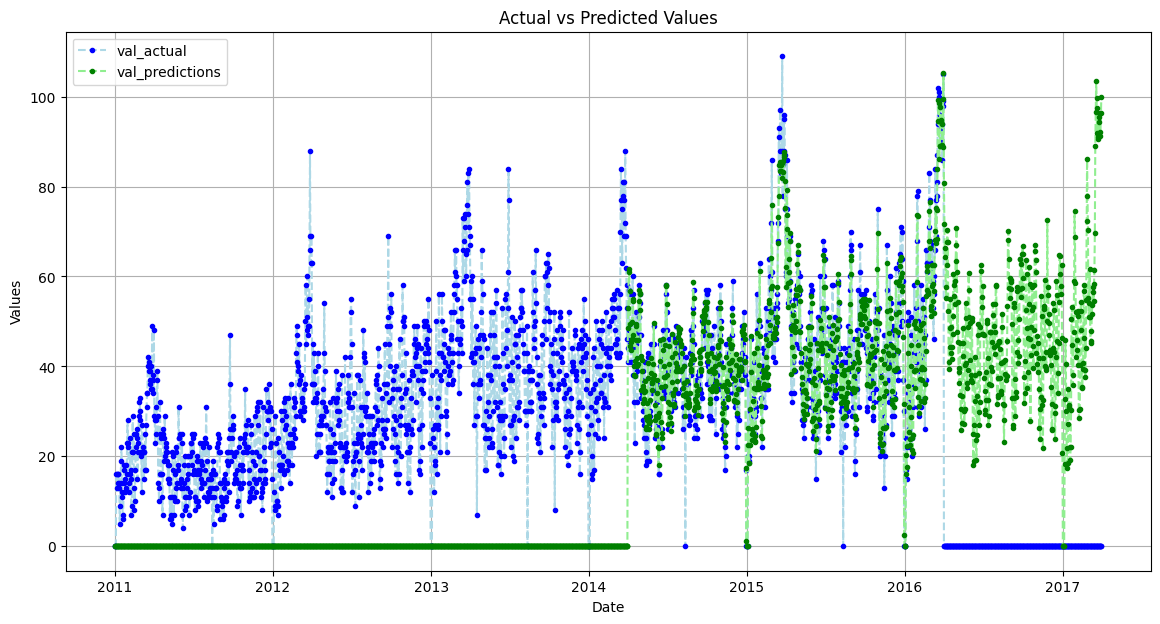

In [367]:
# グラフのサイズを設定
plt.figure(figsize=(14, 7))

# 実際の値（target_true_values）のプロット
plt.plot(valid_df['date'], valid_df['target_true_values'], ls='--', color='lightblue', label='val_actual', marker='o', markersize=3, markerfacecolor='blue', markeredgecolor='blue')

# 予測値（test_predictions_padded_df）のプロット
plt.plot(valid_df['date'], valid_df['test_predictions'], ls='--', color='lightgreen', label='val_predictions', marker='o', markersize=3, markerfacecolor='green', markeredgecolor='green')

# グラフのタイトルとラベル
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')

plt.legend()  # 凡例を表示
plt.grid(True)  # グリッドを表示
plt.show()  # グラフを表示


In [368]:
# 評価範囲
val_actual1 = valid_df['target_true_values'][1186:1551].values  # 2015年度(365日)
val_actual2 = valid_df['target_true_values'][1551:1917].values  # 2016年度(366日)

val_predictions1 = valid_df['test_predictions'][1186:1551].values  # 予測値をnumpy配列に変換
val_predictions2 = valid_df['test_predictions'][1551:1917].values

# MAEの計算
mae = tf.keras.metrics.MeanAbsoluteError()
val_performance1 = mae(val_actual1, val_predictions1).numpy()
val_performance2 = mae(val_actual2, val_predictions2).numpy()

print(f"Validation MAE 2015: {val_performance1}")
print(f"Validation MAE 2016: {val_performance2}")

Validation MAE 2015: 3.9555461406707764
Validation MAE 2016: 4.2863993644714355


D1-S42
Validation MAE 2015: 3.9880948066711426
Validation MAE 2016: 4.26677131652832

D1-Adam(0.0001)
Validation MAE 2015: 5.216155052185059
Validation MAE 2016: 5.638643264770508

D2 ※過学習寄り
Validation MAE 2015: 3.913811206817627
Validation MAE 2016: 4.130071640014648

D1-特徴量（ラグなし）
Validation MAE 2015: 4.066317081451416
Validation MAE 2016: 4.366737365722656

D1-特徴量（ラグ限定追加）
Validation MAE 2015: 4.329614162445068
Validation MAE 2016: 4.483592987060547

D1-特徴量（指標のラグ・差分追加）
Validation MAE 2015: 5.112846851348877
Validation MAE 2016: 5.611062049865723

D1-S123
Validation MAE 2015: 4.365245342254639
Validation MAE 2016: 4.765319347381592

D1-S2024
Validation MAE 2015: 4.020313739776611
Validation MAE 2016: 4.420156478881836

D1-S224
Validation MAE 2015: 4.190972328186035
Validation MAE 2016: 4.559665679931641

D1-S7
Validation MAE 2015: 4.809710502624512
Validation MAE 2016: 5.228385925292969

D1-S100
Validation MAE 2015: 4.446397304534912
Validation MAE 2016: 4.594050407409668

D1-S77
Validation MAE 2015: 4.1079607009887695
Validation MAE 2016: 4.380335807800293

D1-S777
Validation MAE 2015: 4.903522491455078
Validation MAE 2016: 5.324897289276123

D1-S1
Validation MAE 2015: 3.9555461406707764
Validation MAE 2016: 4.2863993644714355

D1-S12
Validation MAE 2015: 4.780707836151123
Validation MAE 2016: 4.916487693786621

D1-S1234
Validation MAE 2015: 4.292367935180664
Validation MAE 2016: 4.589956760406494

D1-S1000
Validation MAE 2015: 4.029196262359619
Validation MAE 2016: 4.433798789978027

D1-S248
Validation MAE 2015: 4.342544078826904
Validation MAE 2016: 4.660150527954102

D1-S3927
Validation MAE 2015: 4.413687229156494
Validation MAE 2016: 4.677678108215332

D1-S17
Validation MAE 2015: 4.8323140144348145
Validation MAE 2016: 5.113615989685059

D1-S1717
Validation MAE 2015: 4.982050895690918
Validation MAE 2016: 5.451369285583496

D1-S73
Validation MAE 2015: 4.698577880859375
Validation MAE 2016: 5.033411979675293

D1-S41
Validation MAE 2015: 4.135928630828857
Validation MAE 2016: 4.4760236740112305

D1-S43
Validation MAE 2015: 4.039188861846924
Validation MAE 2016: 4.284136772155762

D1-S44
Validation MAE 2015: 4.042535305023193
Validation MAE 2016: 4.398341178894043

D1-S2025
Validation MAE 2015: 4.5202131271362305
Validation MAE 2016: 4.847048759460449

In [370]:
# インデックスをリセットして連番にする
submit_test_df = valid_df['test_predictions'][-365:].reset_index(drop=True)

# 休業日の実績を0にする
submit_test_df.iloc[137] = 0
submit_test_df.iloc[274] = 0
submit_test_df.iloc[275] = 0
submit_test_df.iloc[276] = 0
submit_test_df.iloc[277] = 0

# DataFrameを作成
df_submit = pd.DataFrame({
    'datetime': sample_submit.iloc[:, 0].reset_index(drop=True),  # datetime列
    'y': submit_test_df.reset_index(drop=True)  # 1次元のsubmit_test_dfをそのまま使用
})

# CSVとして保存
df_submit.to_csv("submit_moving30_s1.csv", index=False, header=False)
df_submit

,datetime,y
0,2016-04-01,80.833130
1,2016-04-02,71.657913
2,2016-04-03,64.268539
3,2016-04-04,66.435364
4,2016-04-05,57.747875
5,2016-04-06,55.286320
6,2016-04-07,62.480564
7,2016-04-08,67.573135
8,2016-04-09,70.404320
9,2016-04-10,67.589020
